# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [1]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/cmdb/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/cmdb/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bio

### 1b. Create Prediction Pipelines

In [2]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [3]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [4]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [5]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [7]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [8]:
hpa = hpa_cyto

### 2b. Load Images

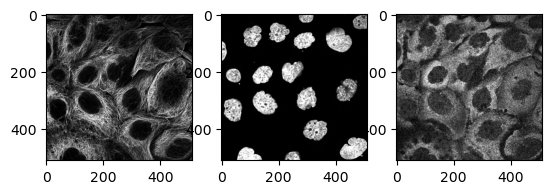

In [9]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [10]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


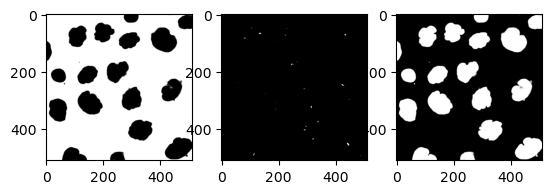

In [11]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [12]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [13]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

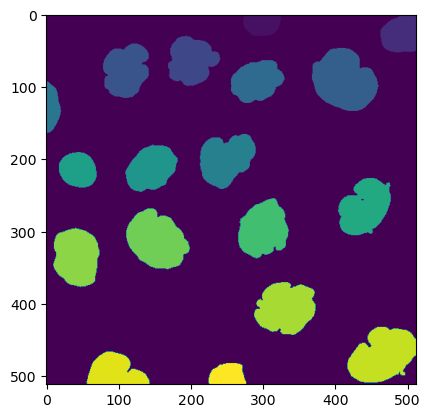

In [14]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [15]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


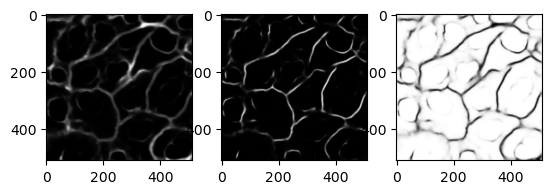

In [16]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

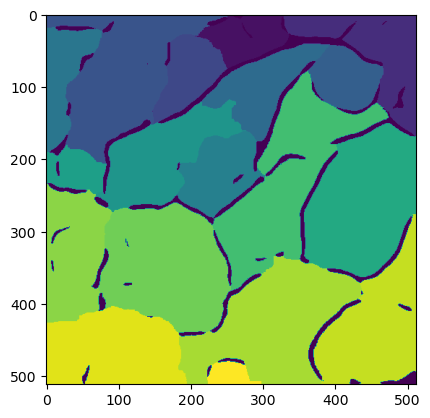

In [17]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [18]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [19]:
sizes

array([15266,  5767, 12324,  6840, 22675,  6456,  9445,  6931,  8782,
       14720,  3887, 24313, 24611, 24695, 13322, 24829, 18173, 17462,
        1646])

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

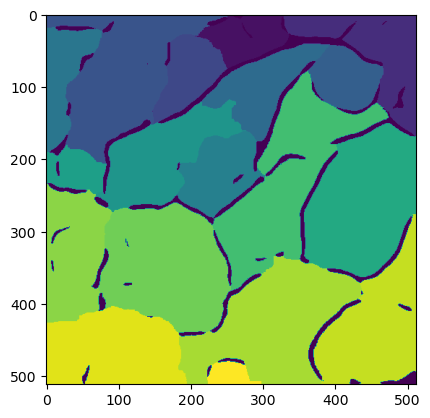

In [20]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [21]:
hpa = hpa_cyto

# Answers

The watershed() function is used for image segmentation, often to separate overlapping regions based on intensity gradients. Its key parameters include:

- image: The intensity or gradient image.
- markers: A labeled array (integer values) where each unique integer corresponds to a seed for a distinct region.
- mask: A boolean array that restricts the segmentation to certain areas.
Effects of Removing Parameters:
- Without mask: Segmentation operates across the entire image, possibly leading to incorrect or noisy boundaries outside the region of interest.
- Without markers: The algorithm cannot differentiate regions, potentially merging areas or failing to segment altogether.

In [22]:
# Adding segmentation evaluation and comparison logic
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.transform import rescale
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import sobel
from skimage.measure import label
from scipy.ndimage import binary_fill_holes

In [23]:
# Function to load and rescale images
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp][0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

In [24]:
# Segmentation evaluation function
def evaluate_segmentation(image, markers, mask=None):
    # Compute gradient
    gradient = sobel(image)

    # Apply watershed
    segmented = watershed(gradient, markers, mask=mask)

    return segmented, gradient

In [25]:
# Visualize segmentation results
def visualize_segmentation(image, segmented, title="Segmentation Results"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(segmented, cmap="nipy_spectral")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [26]:
# Organelles to evaluate
organelles = {
    "cyto": hpa_cyto,
    "endo": hpa_endo,
    "mito": hpa_mito,
    "nucl": hpa_nucl
}

Evaluating segmentation for cyto...


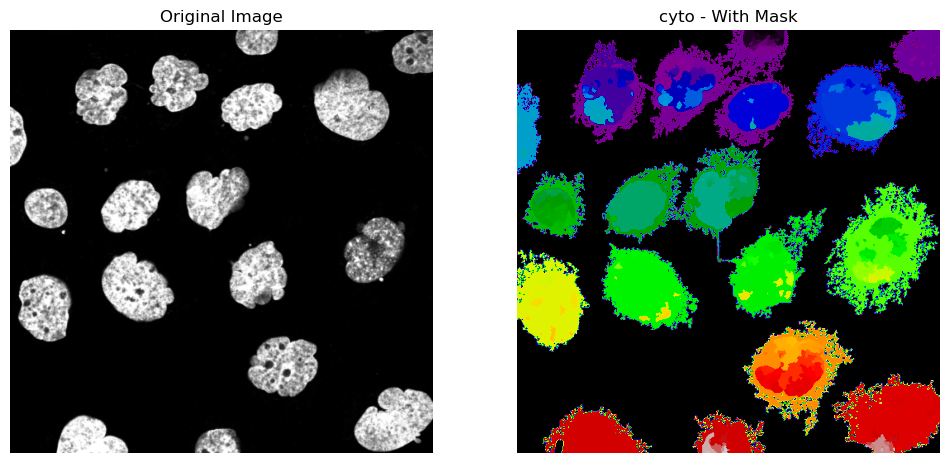

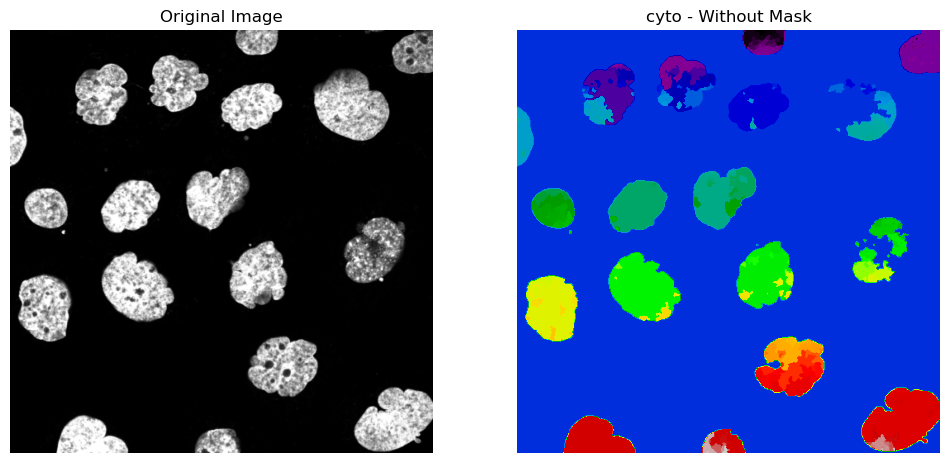

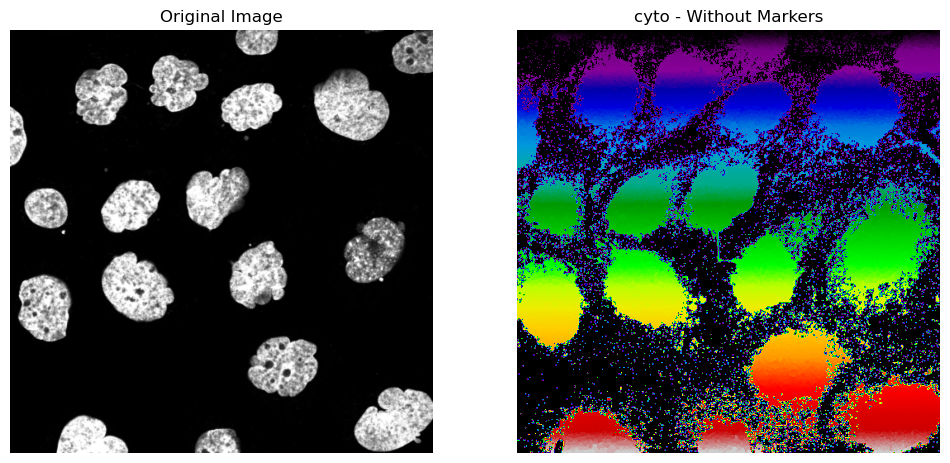

Evaluating segmentation for endo...


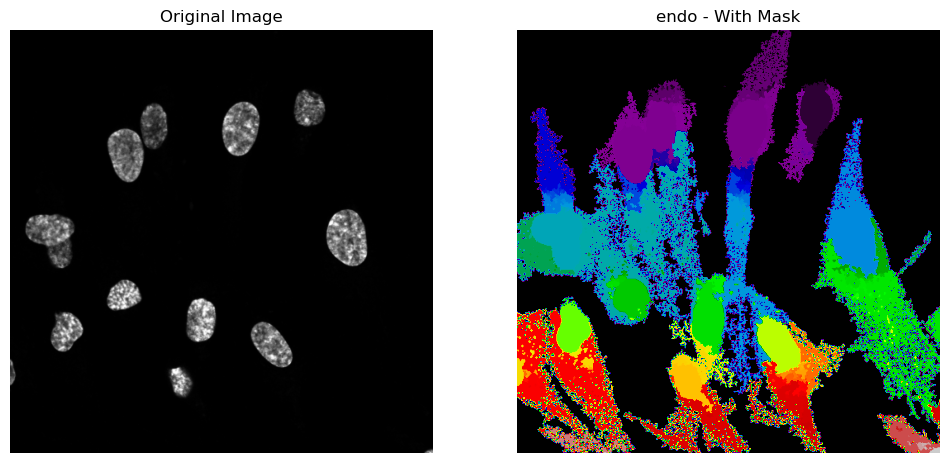

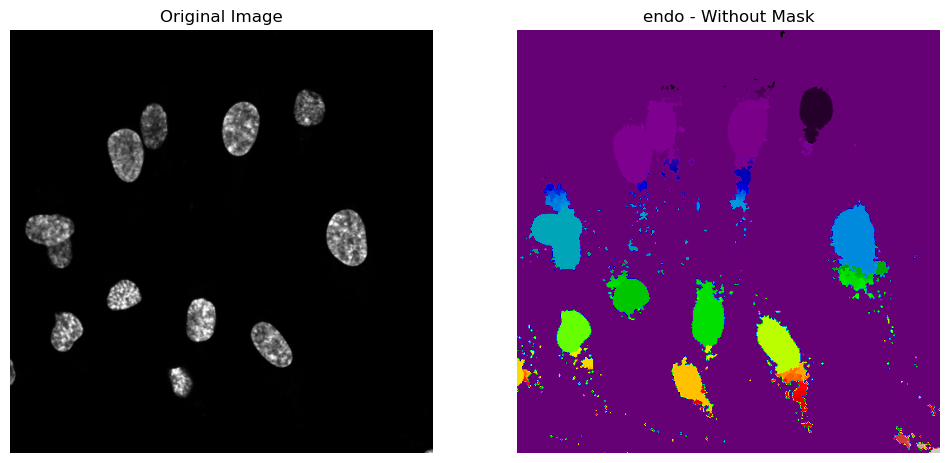

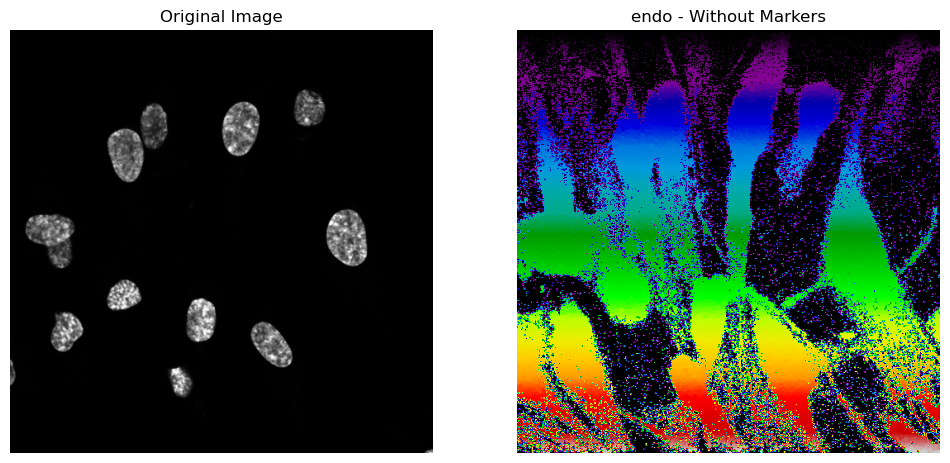

Evaluating segmentation for mito...


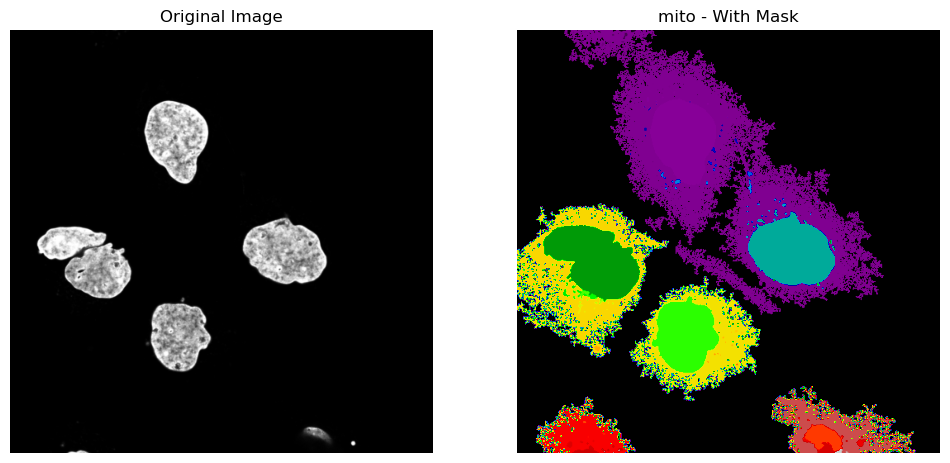

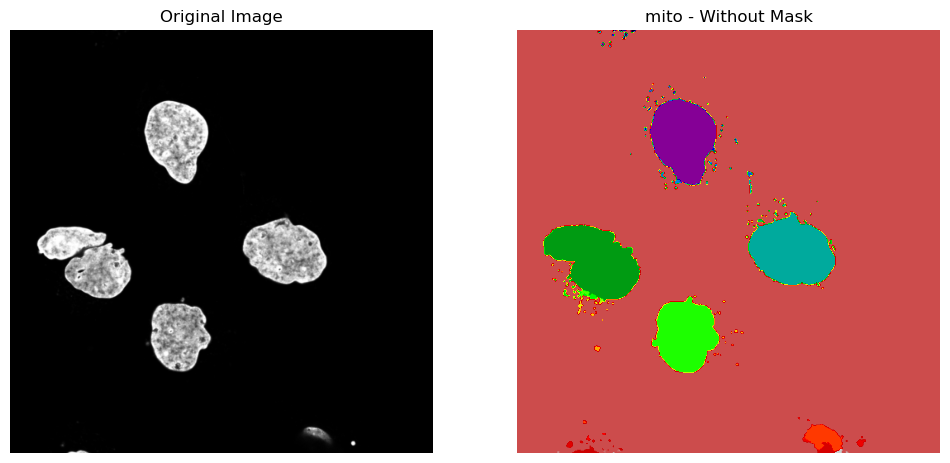

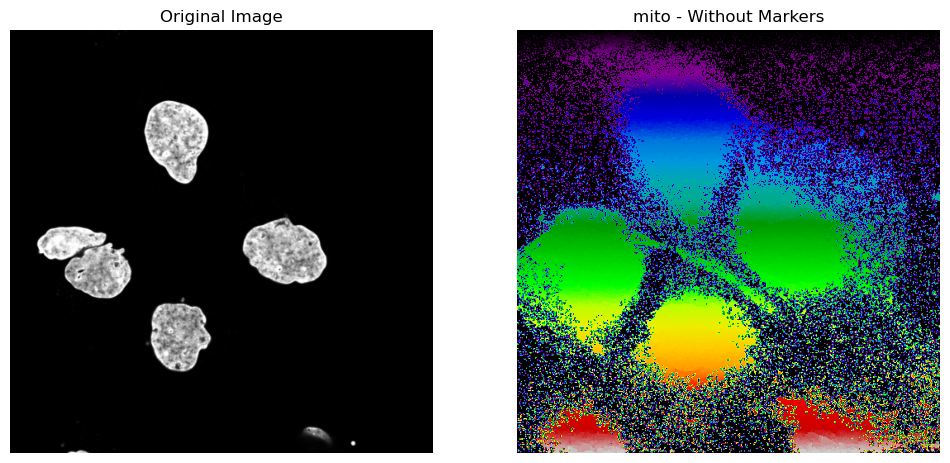

Evaluating segmentation for nucl...


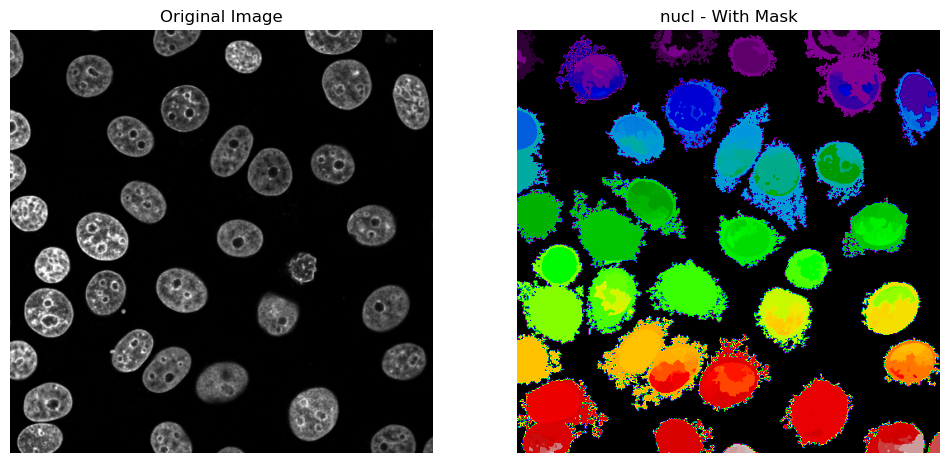

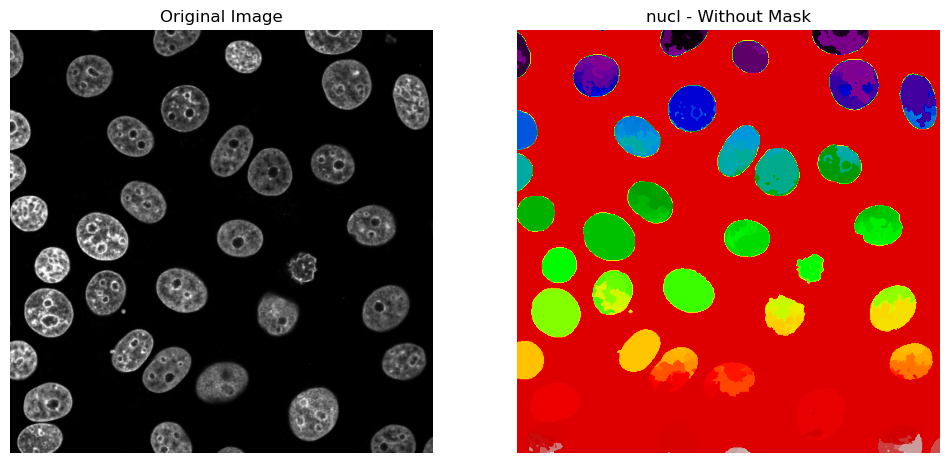

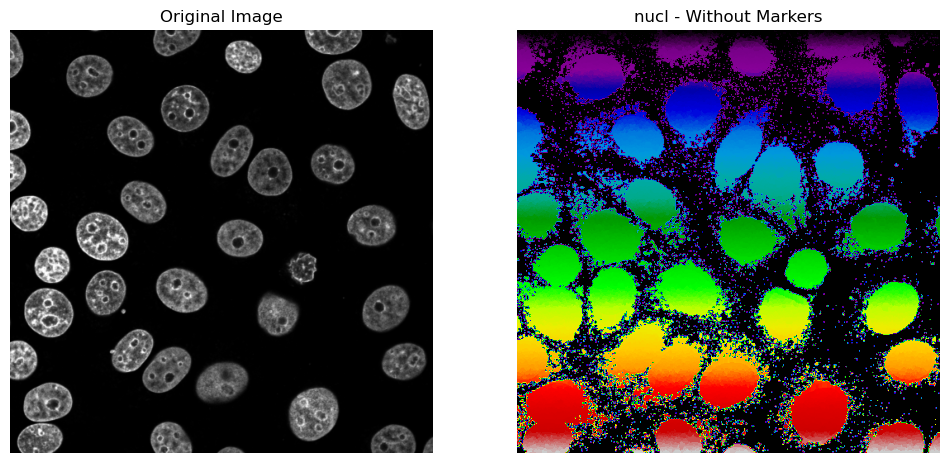

In [33]:
for organelle, hpa in organelles.items():
    print(f"Evaluating segmentation for {organelle}...")

    # Load image
    image = load_image(image_paths[hpa], channels, scale_factor)

    # Use the blue channel for nucleus segmentation
    nucleus_image = image[1, :, :]

    # Create markers (assume binary threshold for simplicity)
    threshold = nucleus_image > np.percentile(nucleus_image, 90)
    markers = label(binary_fill_holes(threshold))

    # Case 1: With mask
    mask = nucleus_image > np.percentile(nucleus_image, 50)
    segmented_with_mask, gradient = evaluate_segmentation(nucleus_image, markers, mask=mask)
    visualize_segmentation(nucleus_image, segmented_with_mask, title=f"{organelle} - With Mask")

    # Case 2: Without mask
    segmented_no_mask, _ = evaluate_segmentation(nucleus_image, markers, mask=None)
    visualize_segmentation(nucleus_image, segmented_no_mask, title=f"{organelle} - Without Mask")

    # Case 3: Without markers (using local maxima as seeds)
    # Generate markers based on local maxima
    # Generate a binary array for local maxima
    coordinates = peak_local_max(-gradient, labels=mask, footprint=np.ones((3, 3)))
    local_maxi = np.zeros_like(gradient, dtype=bool)
    local_maxi[tuple(coordinates.T)] = True  # Convert coordinates to binary mask

    # Label the maxima to create markers
    markers_no_markers = label(local_maxi)

    # Evaluate segmentation without markers
    segmented_no_markers, _ = evaluate_segmentation(nucleus_image, markers_no_markers, mask=mask)
    visualize_segmentation(nucleus_image, segmented_no_markers, title=f"{organelle} - Without Markers")

In [34]:
print("Segmentation evaluation completed.")

Segmentation evaluation completed.


In [ ]:
# 2b Answer

- Segmentation performs best for cyto, where cell boundaries are the clearest. Mito segmentation also works well, while endo and nucl are less effective in comparison. Overall, cyto outperforms the other categories.